<a href="https://colab.research.google.com/github/ross-hugo/Artwork-GAN/blob/main/Discriminator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/ross-hugo/Artwork-GAN/

Cloning into 'Artwork-GAN'...
remote: Enumerating objects: 8183, done.
remote: Counting objects: 100% (8183/8183), done.
remote: Compressing objects: 100% (8182/8182), done.
remote: Total 8183 (delta 3), reused 8173 (delta 1), pack-reused 0
Receiving objects: 100% (8183/8183), 34.61 MiB | 31.59 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [2]:
cd Artwork-GAN/

/content/Artwork-GAN


In [3]:
from keras.preprocessing.image import ImageDataGenerator
dir = "images/"

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    dir,
    subset="training",
    target_size=(128, 128),
    color_mode='rgb',
    shuffle = False,
    batch_size=128,
    class_mode='binary')

test_generator = train_datagen.flow_from_directory(
    dir,
    subset="validation",
    target_size=(128, 128),
    color_mode='rgb',
    shuffle = False,
    batch_size=128,
    class_mode='binary')

Found 6516 images belonging to 49 classes.
Found 1602 images belonging to 49 classes.


In [4]:
train_generator.class_indices

{'alfred_sisley': 0,
 'amedeo_modigliani': 1,
 'andrei_rublev': 2,
 'andy_warhol': 3,
 'camille_pissarro': 4,
 'caravaggio': 5,
 'claude_monet': 6,
 'diego_rivera': 7,
 'diego_velazquez': 8,
 'edgar_degas': 9,
 'edouard_manet': 10,
 'edvard_munch': 11,
 'el_greco': 12,
 'eugene_delacroix': 13,
 'francisco_goya': 14,
 'frida_kahlo': 15,
 'georges_seurat': 16,
 'giotto_di_bondone': 17,
 'gustav_klimt': 18,
 'gustave_courbet': 19,
 'henri_de_toulouse-lautrec': 20,
 'henri_matisse': 21,
 'henri_rousseau': 22,
 'hieronymus_bosch': 23,
 'jackson_pollock': 24,
 'jan_van_eyck': 25,
 'joan_miro': 26,
 'kazimir_malevich': 27,
 'leonardo_da_vinci': 28,
 'marc_chagall': 29,
 'michelangelo': 30,
 'mikhail_vrubel': 31,
 'pablo_picasso': 32,
 'paul_cezanne': 33,
 'paul_gauguin': 34,
 'paul_klee': 35,
 'peter_paul_rubens': 36,
 'pierre-auguste_renoir': 37,
 'piet_mondrian': 38,
 'pieter_bruegel': 39,
 'raphael': 40,
 'rembrandt': 41,
 'rene_magritte': 42,
 'salvador_dali': 43,
 'sandro_botticelli': 44

In [5]:
NUM_CLASSES = len(train_generator.class_indices)
NUM_CLASSES

49

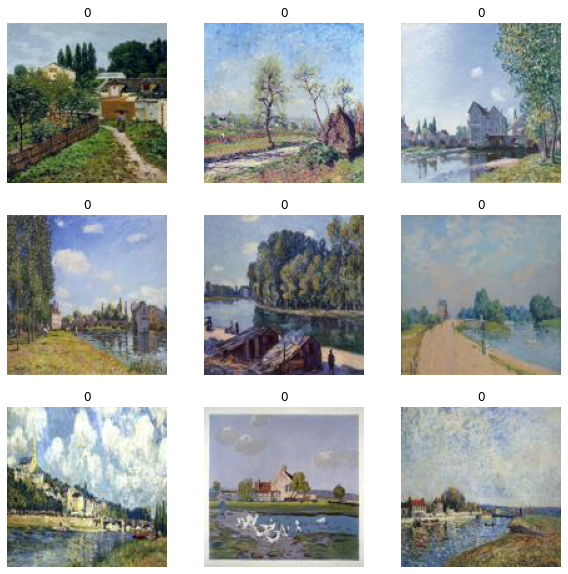

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
images, labels = train_generator.next()
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(int(labels[i]))
    plt.axis("off")

In [7]:

from keras.datasets import mnist #for testing on some data
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, GlobalAveragePooling1D

from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers.convolutional import UpSampling2D, Conv2D
import matplotlib.pyplot as plt
import sys
import numpy as np
import numpy as np
from scipy import ndimage
from keras.losses import binary_crossentropy
from keras.backend import ones_like, zeros_like


#losses: rotation loss & hinge loss (for the true versus fake prediction)
#penalties (such as the gradient penalty)
#normalization techniques: self-modulated batch normalization which doesnt require labels
#neural architecture: ResNet
#evaluation metrics: FID score
#ResNet contains 6 blocks
#I'm assuming that we will have a GAN class and inside that class we'll have the discriminator and generator functions

class Discriminator():
  
  # def __init__(self, flags, data):
  def __init__(self):
    self.resnet = None
    self.lrelu = None
    self.sn  = None
    # self.input_shape = (28, 28, 1) 
    self.img_shape = ( 28, 28, 1)
    self.model = None

#discriminator outputs likelihood of image being real
  # def discriminator(self, resnet):
  def define_model(self):  
     #as per paper batch normalization is omitted in the discriminator
     #leakyRelu / conv / leakyrelu / conv
     #4 resblocks --> relu, global sum pooling, dense 

      model = Sequential()
      
      #block1
      model.add(LeakyReLU(alpha=0.2))
      model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
      model.add(LeakyReLU(alpha=0.2))
      model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))


      #block2
      model.add(LeakyReLU(alpha=0.2))
      model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
      model.add(LeakyReLU(alpha=0.2))
      model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
      
      #block3
      model.add(LeakyReLU(alpha=0.2))
      model.add(Conv2D(128, kernel_size=3, strides=2,  padding="same"))
      model.add(LeakyReLU(alpha=0.2))
      model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))

      #block4
      model.add(LeakyReLU(alpha=0.2))
      model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
      model.add(LeakyReLU(alpha=0.2))
      model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))

      #add ReLU layer
      model.add(LeakyReLU(alpha=0.2))

      #add global sum pooling layer (is sum pooling the same as average pooling?) - also what parameters to be added here?
      # model.add(GlobalAveragePooling1D(self.input_shape)) # (batch_size, steps, features)
      
      model.add(Flatten())
      
      lr = 1e-4
      betas = (.9, .99)
      opt = Adam(learning_rate=lr, beta_1= betas[0], beta_2=betas[1])
      model.compile(loss="binary_crossentropy", optimizer=opt)
      
      self.model = model
      return self.model

  def train_epoch(self, X, y ):
    assert len(X) == len(y)
    for i ,data in enumerate(X):
      # Get generated data from generator
      # x = generated_data
      # x_90 = rotate_img(x, 90)
      # x_180 = rotate_img(x, 180)
      # x_270 = rotate_img(x, 270)


      x = data
      x_90 = rotate_img(x, 90)
      x_180 = rotate_img(x, 180)
      x_270 = rotate_img(x, 270)
      new_image = np.vstack(x, x_90, x_180, x_270)

    return new_image

  def train(self, epochs, batch_size=128, save_interval=500):
    # #load real images
    # (X_train,_), (Y_train,_) = mnist.load_data() #we're not gonna use Y_train but it bothers me to leave it out

    # #normalize data (-1 to 1) 
    # #if you want to do 0 to 1 change 127.5 to 255
    # # X_train = (X_train.astype(np.float32)-127.5) /127.5
    # # X_train = X_train.astype(np.float32)/255
    # #add dimension, if input to gen and discr has shape 28x28x1, then 3 dimensions
    # X_train = np.expand_dims(X_train, axis=3)
    # half_size = int(batch_size/2)

    # for epoch in range(epochs)
    #     idx = np.random.randint(0, X_train.shape[0], half_size)
    #     imgs = X_train[idx]

    #     #half batch number of vectors, each of size 100
    #     noise = np.random.normal(0,1,(half_size, 100)) #for generator
    #     #generate half batch of fake images
    #     gen_imgs = generator.predict(noise)

    #     ########################
    #     #Training Discriminator#
    #     ########################
    #     #train discriminator on real images
    #     d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
    #     #train discriminator on fake images
    #     d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_size,1)))
    #     #averaged loss
    #     d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #add and divide by 2


    #     ########################
    #     ###Training Generator###
    #     ########################
    #     #generating fake images
    #     noise = np.random.normal(0,1,(batch_size, 100)) 
    #     #telling discriminator the image is real
    #     valid_y = np.array([1] * batch_size)

    #     g_loss = combined.train_on_batch(noise, valid_y)
      pass

  def rotate_img(img, rot):
      if rot == 0:  # 0 degrees rotation
          return img
      # elif rot == 90:  # 90 degrees rotation
      #     return np.flipud(np.transpose(img, (1, 0, 2)))
      # elif rot == 180:  # 90 degrees rotation
      #     return np.fliplr(np.flipud(img))
      # elif rot == 270:  # 270 degrees rotation / or -90
      #     return np.transpose(np.flipud(img), (1, 0, 2))
      # elif rot == 120:
      #     return ndimage.rotate(img, 120, reshape=False)
      # elif rot == 240:
      #     return ndimage.rotate(img, 240, reshape=False)
      # else:
      #     raise ValueError('rotation error')
      elif rot == 90:
        return np.rot90(img,k=1, axes=(1,2))
      elif rot == 180:
        return np.rot90(img,k=2, axes=(1,2))
      elif rot == 270:
        return np.rot90(img,k=3, axes=(1,2))
      else:
        raise ValueError("rotation not valid")
  
  def get_loss(self, real_output, fake_output):
    real_loss = binary_crossentropy(ones_like(real_output), real_output)
    fake_loss = binary_csoosentropy(zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

  #function to predict whether an image is real or fake 
  def predict_real_fake():
    pass
  


  #function to predict what rotation angle we're working with
  def rotation_angle():
    pass

      

In [8]:
from keras.datasets import mnist 
# from discriminator import Discriminator
from keras.utils import to_categorical

D = Discriminator()
D_model = D.define_model()
decision = D_model(images)
print(decision)

tf.Tensor(
[[-3.3311153e-05  2.1593634e-04 -8.7897562e-05 ... -9.6997392e-05
   2.1243969e-03  4.8685973e-04]
 [-1.5629757e-04 -2.3498409e-04 -1.2585845e-04 ... -2.2445041e-04
   2.7886755e-03  1.3725456e-03]
 [-1.9576079e-04 -8.9976958e-05 -6.2156265e-05 ... -1.7683800e-04
   3.1695501e-03  3.4965898e-04]
 ...
 [ 9.7044942e-04  2.3661624e-04  3.6409235e-04 ...  5.0252696e-05
   1.4131612e-03  1.0699015e-03]
 [-7.4804528e-05  2.8010638e-04 -5.1766427e-05 ... -2.6876596e-04
   2.9966952e-03  1.0518827e-03]
 [-2.8762314e-04 -1.6497349e-04 -3.9547605e-05 ... -6.5619344e-05
   1.4978359e-03  5.1461085e-04]], shape=(128, 256), dtype=float32)


In [ ]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

class GAN():
    def __init__(self):
        self.img_rows = 128
        self.img_cols = 128
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()
      
        #block1
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))


        #block2
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        
        #block3
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(128, kernel_size=3, strides=2,  padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))

        #block4
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))

        #add ReLU layer
        model.add(LeakyReLU(alpha=0.2))

        #add global sum pooling layer (is sum pooling the same as average pooling?) - also what parameters to be added here?
        # model.add(GlobalAveragePooling1D(self.input_shape)) # (batch_size, steps, features)
      
        model.add(Flatten())

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, X_train , epochs, batch_size=128, sample_interval=50, ):

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    gan = GAN()
    gan.train(images,epochs=100, batch_size=32, sample_interval=200)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 1024)             

KeyboardInterrupt: ignored

In [ ]:
#discriminator would use a resnet architecture
#how to build a resnet as a discriminator
#what are the parameters that they've used for the ResNet?
#will start here by building the resnet
#--------> I'll continue working in the discriminator.py file

###anna's sudo code pls ignore
#for epoch in range(num_epoch):
   #train model
   #for each id in ... the dataset
      #first "optimize"
      #image = "image"
      #representation = model(image)
      # #calculate loss
      # optimize 




def rotate_img(img, rot):
  if rot == 0:  # 0 degrees rotation
    return img
  elif rot == 90:
    return np.rot90(img,k=1, axes=(1,2))
  elif rot == 180:
    return np.rot90(img,k=2, axes=(1,2))
  elif rot == 270:
    return np.rot90(img,k=3, axes=(1,2))
  else:
    raise ValueError("rotation not valid")
 

def train_epoch(X, y ):
  assert len(X) == len(y)
  for i ,data in enumerate(X):
    # Get generated data from generator
    # x = generated_data
    # x_90 = rotate_img(x, 90)
    # x_180 = rotate_img(x, 180)
    # x_270 = rotate_img(x, 270)


    x = data
    x_90 = rotate_img(x, 90)
    x_180 = rotate_img(x, 180)
    x_270 = rotate_img(x, 270)
    new_image = np.vstack(x, x_90, x_180, x_270)

  return new_image

# train_data_gen = get_data_generator(X_train, y_train)
# test_data_gen = get_data_generator(X_test, y_test)

# print(model.evaluate_generator(train_data_gen))





In [ ]:
# #discriminator.py
# from keras.datasets import mnist #for testing on some data
# from keras.layers import Input, Dense, Reshape, Flatten, Dropout, ReLU, AveragePooling2D
# from keras.layers import BatchNormalization, Activation, ZeroPadding2D, GlobalAveragePooling1D

# from keras.layers.advanced_activations import LeakyReLU
# from keras.models import Sequential, Model
# from keras.optimizers import Adam
# from keras.layers.convolutional import UpSampling2D, Conv2D
# import matplotlib.pyplot as plt
# import sys
# import numpy as np
# from scipy import ndimage
# from keras.backend import sum


# #losses: rotation loss & hinge loss (for the true versus fake prediction)
# #penalties (such as the gradient penalty)
# #normalization techniques: self-modulated batch normalization which doesnt require labels
# #neural architecture: ResNet
# #evaluation metrics: FID score
# #ResNet contains 6 blocks
# #I'm assuming that we will have a GAN class and inside that class we'll have the discriminator and generator functions

# class Discriminator():
  
#   # def __init__(self, flags, data):
#   def __init__(self):
#     self.resnet = None
#     self.lrelu = None
#     self.sn  = None
#     # self.input_shape = (28, 28, 1) 
#     self.img_shape = (128, 128, 3)
#     self.model = None

#   #discriminator outputs likelihood of image being real
#   # def discriminator(self, resnet):
#   def define_model(self):  
#      #as per paper batch normalization is omitted in the discriminator
#      #leakyRelu / conv / leakyrelu / conv
#      #4 resblocks --> relu, global sum pooling, dense 

#       model = Sequential()
#       channel = 3
#       # Conv1D(filters=32, kernel_size=8, input_shape=(5000,1), strides=1, padding='same')
#       #nn.Conv1d(in_channels=1, out_channels=32, kernel_size=7, stride=1, padding=3) # different kernel size

#       #block1 3, 128 , down_sampling = True, is_start = True
#       model.add( Conv2D(128, kernel_size=3, strides=1 ,input_shape=self.img_shape, padding="same"))
#       model.add(ReLU())
#       model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
#       model.add(ReLU())
#       model.add(AveragePooling2D(2,2))
#       # AvgPool2d(2, 2, padding = 1) kernel, stride

#       #block2 down_sampling = True,
#       model.add(ReLU()) 
#       model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
#       model.add(ReLU())
#       model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
#       model.add(AveragePooling2D(2,2))
      
#       #block3
#       model.add(ReLU())
#       model.add(Conv2D(128, kernel_size=3, strides=1,  padding="same"))
#       model.add(ReLU())
#       model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))

#       #block4
#       model.add(ReLU())
#       model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
#       model.add(ReLU())
#       model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))

#       #add ReLU layer
#       model.add(ReLU())

#        #add global sum pooling layer (is sum pooling the same as average pooling?) - also what parameters to be added here?
#       # torch.sum(block4, dim=(2,3))
#       # sum()
#       # model.add(GlobalAveragePooling1D(self.input_shape)) # (batch_size, steps, features)
      
#       # linear(128, 1)
#       model.add(Dense(1))

#       lr = 1e-4
#       betas = (.9, .99)
#       opt = Adam(learning_rate=lr, beta_1= betas[0], beta_2=betas[1])
#       model.compile(loss="binary_crossentropy", optimizer=opt)
      
#       self.model = model
#       return self.model

#   def train(self, epochs, batch_size=128, save_interval=500):
#     # #load real images
#     # (X_train,_), (Y_train,_) = mnist.load_data() #we're not gonna use Y_train but it bothers me to leave it out

#     # #normalize data (-1 to 1) 
#     # #if you want to do 0 to 1 change 127.5 to 255
#     # # X_train = (X_train.astype(np.float32)-127.5) /127.5
#     # # X_train = X_train.astype(np.float32)/255
#     # #add dimension, if input to gen and discr has shape 28x28x1, then 3 dimensions
#     # X_train = np.expand_dims(X_train, axis=3)
#     # half_size = int(batch_size/2)

#     # for epoch in range(epochs)
#     #     idx = np.random.randint(0, X_train.shape[0], half_size)
#     #     imgs = X_train[idx]

#     #     #half batch number of vectors, each of size 100
#     #     noise = np.random.normal(0,1,(half_size, 100)) #for generator
#     #     #generate half batch of fake images
#     #     gen_imgs = generator.predict(noise)

#     #     ########################
#     #     #Training Discriminator#
#     #     ########################
#     #     #train discriminator on real images
#     #     d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
#     #     #train discriminator on fake images
#     #     d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_size,1)))
#     #     #averaged loss
#     #     d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #add and divide by 2


#     #     ########################
#     #     ###Training Generator###
#     #     ########################
#     #     #generating fake images
#     #     noise = np.random.normal(0,1,(batch_size, 100)) 
#     #     #telling discriminator the image is real
#     #     valid_y = np.array([1] * batch_size)

#     #     g_loss = combined.train_on_batch(noise, valid_y)
#       pass

#   #function to predict whether an image is real or fake 
#   def predict_real_fake():
#     pass

#   #function to predict what rotation angle we're working with
#   def rotation_angle():
#     pass
